<a href="https://colab.research.google.com/github/KelseyWang2022/accident_data_analysis/blob/main/Wasserstein_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import os

# 设置随机种子以确保结果可重复
torch.manual_seed(42)
np.random.seed(42)

# 检查GPU是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. 导入数据集
file_path = '/content/cleaned_data_final.csv'

if not os.path.exists(file_path):
    raise FileNotFoundError(f"文件路径 {file_path} 不存在。请检查路径是否正确。")

data = pd.read_csv(file_path)

# 2. 合并类别0和3为"severe/death"
data['grav_balanced'] = data['grav'].replace({0: 3, 3: 3})

# 3. 数据预处理
numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()
if 'grav' in numeric_columns:
    numeric_columns.remove('grav')  # 确保不包含目标列

features = data[numeric_columns]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# 将特征转化为PyTorch tensor，并转移到GPU
X = torch.tensor(scaled_features, dtype=torch.float32).to(device)
y = torch.tensor(data['grav_balanced'].values, dtype=torch.float32).to(device)

# 创建数据加载器
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# 4. 定义WGAN模型
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, output_dim),
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
        )

    def forward(self, x):
        return self.model(x)

# 初始化模型权重
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

generator = Generator(100, X.shape[1]).to(device)
discriminator = Discriminator(X.shape[1]).to(device)
generator.apply(weights_init)
discriminator.apply(weights_init)

# 5. 设置超参数
z_dim = 100
lr = 1e-5  # 调低学习率
n_epochs = 1000
n_critic = 5
clip_value = 0.01

optimizer_G = optim.RMSprop(generator.parameters(), lr=lr)
optimizer_D = optim.RMSprop(discriminator.parameters(), lr=lr)

# 6. 训练WGAN
for epoch in range(1, n_epochs + 1):
    for i, (real_data, _) in enumerate(dataloader):
        batch_size = real_data.size(0)
        real_data = real_data.to(device)

        # 训练判别器
        for _ in range(n_critic):
            optimizer_D.zero_grad()
            real_output = discriminator(real_data)
            real_loss = -torch.mean(real_output)

            z = torch.randn(batch_size, z_dim).to(device)
            fake_data = generator(z)
            fake_output = discriminator(fake_data.detach())
            fake_loss = torch.mean(fake_output)

            d_loss = real_loss + fake_loss
            d_loss.backward()
            optimizer_D.step()

            for p in discriminator.parameters():
                p.data.clamp_(-clip_value, clip_value)

        # 训练生成器
        optimizer_G.zero_grad()
        z = torch.randn(batch_size, z_dim).to(device)
        fake_data = generator(z)
        fake_output = discriminator(fake_data)
        g_loss = -torch.mean(fake_output)
        g_loss.backward()
        optimizer_G.step()

    if epoch % 100 == 0 or epoch == 1:
        print(f"Epoch [{epoch}/{n_epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

# 7. 生成合成数据
desired_samples = max(data['grav_balanced'].value_counts().drop(3).values) - data['grav_balanced'].value_counts()[3]
n_synthetic = int(desired_samples)

z = torch.randn(n_synthetic, z_dim).to(device)
with torch.no_grad():
    synthetic_data = generator(z).cpu().numpy()

# 还原到原始特征的尺度
synthetic_data_original_scale = scaler.inverse_transform(synthetic_data)

# 创建合成数据框架
synthetic_df = pd.DataFrame(synthetic_data_original_scale, columns=numeric_columns)
synthetic_df['grav_balanced'] = 3  # 添加合并后的类别

# 8. 合并数据并保存
balanced_data = pd.concat([data, synthetic_df], ignore_index=True)
balanced_data.to_csv('balanced_accidents_dataset.csv', index=False)
print("\n平衡后的数据集已保存为 'balanced_accidents_dataset.csv'")


Using device: cuda
Epoch [1/1000] | D Loss: -0.1780 | G Loss: 0.0038
Epoch [100/1000] | D Loss: -0.0733 | G Loss: -0.0422
Epoch [200/1000] | D Loss: -0.0371 | G Loss: -0.0106
Epoch [300/1000] | D Loss: -0.1466 | G Loss: 0.0941
Epoch [400/1000] | D Loss: -0.0204 | G Loss: -0.0083
Epoch [500/1000] | D Loss: -0.1166 | G Loss: 0.0902
Epoch [600/1000] | D Loss: -0.0466 | G Loss: 0.0141
Epoch [700/1000] | D Loss: -0.0498 | G Loss: 0.0169
Epoch [800/1000] | D Loss: -0.0391 | G Loss: 0.0110
Epoch [900/1000] | D Loss: -0.0659 | G Loss: 0.0251
Epoch [1000/1000] | D Loss: -0.0758 | G Loss: 0.0558

平衡后的数据集已保存为 'balanced_accidents_dataset.csv'


In [3]:
data_1 = pd.read_csv('/content/balanced_accidents_dataset.csv')
print(data_1.columns)

Index(['Unnamed: 0', 'Num_Acc', 'an', 'mois', 'jour', 'hrmn', 'lum', 'agg',
       'int', 'atm', 'col', 'com', 'adr', 'gps', 'lat', 'long', 'dep',
       'season', 'week', 'peak', 'nbv', 'catr', 'circ', 'vosp', 'prof', 'plan',
       'surf', 'infra', 'situ', 'senc', 'catv', 'occutc', 'obs', 'obsm',
       'choc', 'manv', 'num_veh_x', 'catu', 'grav', 'sexe', 'trajet', 'secu',
       'an_nais', 'num_veh_y', 'age', 'year', 'grav_balanced'],
      dtype='object')


In [5]:
print(data_1['grav_balanced'].value_counts())

grav_balanced
3    10399
2    10399
1    10194
Name: count, dtype: int64


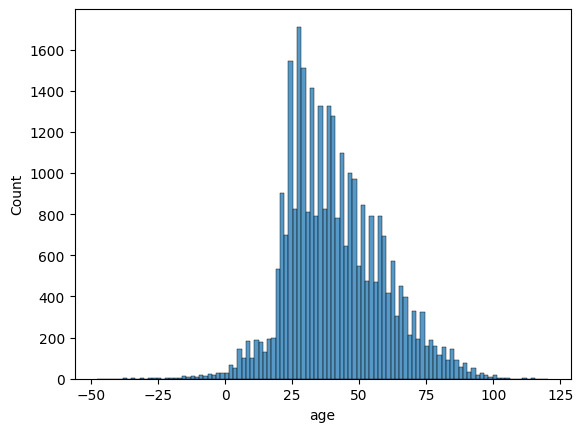

In [6]:

import seaborn as sns
import matplotlib.pyplot as plt
#查看特征列名

#统计年龄的分布
sns.histplot(data_1['age'])
plt.show()
